# Data Load and Imports

In [103]:
#basic
import pandas as pd
import numpy as np
import re
import math
from datetime import datetime
import sys#print(sys.executable)
# import pycountry
# from bs4 import BeautifulSoup  as soup
# import requests

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#warning
import warnings
warnings.filterwarnings('ignore')

#statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

#scitkit-learn
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV , train_test_split as split

In [67]:
df_dev=pd.read_excel("Data_Train.xlsx",parse_dates=['Date_of_Journey'])
df_test=pd.read_excel("Test_set.xlsx",parse_dates=['Date_of_Journey'])
df_dev.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
def featute_distribution(df):
    print(f'dataset shape {df.shape}')
    table=pd.DataFrame(df_dev.dtypes,columns=["type"]).reset_index()
    table['feature']=table['index']
    table=table[['feature','type']]
    table["nulls"]=df.isnull().sum().values/len(df)
    table["num_uniques"]=df.nunique().values
    table["uniques_percenatges"]=df.nunique().values/len(df)

    return table

featute_distribution(df_dev)

dataset shape (10683, 11)


,feature,type,nulls,num_uniques,uniques_percenatges
0,Airline,object,0.000000,12,0.001123
1,Date_of_Journey,datetime64[ns],0.000000,40,0.003744
2,Source,object,0.000000,5,0.000468
3,Destination,object,0.000000,6,0.000562
4,Route,object,0.000094,128,0.011982
5,Dep_Time,object,0.000000,222,0.020781
6,Arrival_Time,object,0.000000,1343,0.125714
7,Duration,object,0.000000,368,0.034447
8,Total_Stops,object,0.000094,5,0.000468
9,Additional_Info,object,0.000000,10,0.000936


In [118]:
df_dev[df_dev['duration']=='5m']

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price
6474,Air India,2019-03-06,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327


# DATA Cleaning

In [68]:
df_dev['Route'].iloc[9039]='DEL → MAA → COK'
df_dev['Total_Stops'].iloc[9039]='1 stop'
df_dev=df_dev.drop(index=6474)
df_test=df_dev.drop(index=2660)

df_dev.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [69]:
def calc_duration(time):
    """normalize the duration time into minutes for consistency reasons"""
    if time.split(' ')==2 :
        new_time=(int(time.split(' ')[0].split('h')[0])*60) + int(time.split(' ')[1].split('m')[0])
    
    else:
        new_time=(int(time.split(' ')[0].split('h')[0])*60)
    
    return new_time

def military_time_conversion(time):

    # Split the string at the colon
    hour, minutes = time.split(":")

    # Convert hour and minutes to integers
    hour_int = int(hour)
    minutes_int = int(minutes)
    
    # This depends on your desired format for the integer representation of time
    # Example 1: Military time (hours * 100 + minutes)
    military_time = hour_int * 100 + minutes_int

    
    return military_time


def df_cleaning_pipeline(df):
    """a df uniform pipeline to make sure the dev and the test df are structrued alike"""
    df=df.rename(lambda col: col.lower(),axis=1).rename(lambda col: col.strip(),axis=1)
    df['route']=df['route'].apply(lambda x: x.split('→'))
    df['total_stops']=df['total_stops'].apply(lambda x: re.sub(r'[^0-9]','',x) if re.sub(r'[^0-9]','',x) else 0)
    df['total_stops']=df['total_stops'].astype(int)
    df['arrival_time']=df['arrival_time'].apply(lambda x: x.split(' ')[0])
    df['departure_military_time']=df['dep_time'].apply(lambda x: military_time_conversion(x))
    df['duration']=df['duration'].apply(lambda x: calc_duration(x))
    df['additional_info']=df['additional_info'].apply(lambda x: x.lower())
    df['additional_info']=df['additional_info'].apply(lambda x: 'layover' if 'layover' in x else x)
    df=df[(df['additional_info']!='Red-eye flight') & (df['additional_info']!='red-eye flight')]

    return df

In [70]:
df=df_cleaning_pipeline(df_dev)
test=df_cleaning_pipeline(df_test)
df

,airline,date_of_journey,source,destination,route,dep_time,arrival_time,duration,total_stops,additional_info,price,departure_military_time
0,IndiGo,2019-03-24,Banglore,New Delhi,"[BLR , DEL]",22:20,01:10,120,0,no info,3897,2220
1,Air India,2019-05-01,Kolkata,Banglore,"[CCU , IXR , BBI , BLR]",05:50,13:15,420,2,no info,7662,550
2,Jet Airways,2019-06-09,Delhi,Cochin,"[DEL , LKO , BOM , COK]",09:25,04:25,1140,2,no info,13882,925
3,IndiGo,2019-05-12,Kolkata,Banglore,"[CCU , NAG , BLR]",18:05,23:30,300,1,no info,6218,1805
4,IndiGo,2019-03-01,Banglore,New Delhi,"[BLR , NAG , DEL]",16:50,21:35,240,1,no info,13302,1650
...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,2019-04-09,Kolkata,Banglore,"[CCU , BLR]",19:55,22:25,120,0,no info,4107,1955
10679,Air India,2019-04-27,Kolkata,Banglore,"[CCU , BLR]",20:45,23:20,120,0,no info,4145,2045
10680,Jet Airways,2019-04-27,Banglore,Delhi,"[BLR , DEL]",08:20,11:20,180,0,no info,7229,820
10681,Vistara,2019-03-01,Banglore,New Delhi,"[BLR , DEL]",11:30,14:10,120,0,no info,12648,1130


# EDA

In [7]:
# lets see corr between featurs to see multicollinarty
correlation_matrix = df.select_dtypes("number").drop(columns=['price']).corr()
high_corr = correlation_matrix[(correlation_matrix >= 0.6) & (correlation_matrix !=1.0)]
high_corr = high_corr.stack().reset_index()
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = high_corr.dropna()
print(f'quite high correlation:\n{high_corr.iloc[0]}')

quite high correlation:
Variable 1        duration
Variable 2     total_stops
Correlation       0.740197
Name: 0, dtype: object


In [8]:
# definiation of numeric df columns
numeric_cols=df.select_dtypes("number").drop(columns=['price'])
# VIF dataframe 
vif=pd.DataFrame()
vif["feature"] = numeric_cols.columns 
  
# calculating VIF for each feature 
vif["VIF"] = [variance_inflation_factor(numeric_cols.values, i) 
                          for i in range(len(numeric_cols.columns))] 
  
print(f"VIF score under 5 is ok, over 10 means multicollinearity suspicious\n{vif.sort_values(by='VIF', ascending=False)}")

VIF score under 5 is ok, over 10 means multicollinearity suspicious
                   feature       VIF
0                 duration  5.401059
1              total_stops  5.211523
2  departure_military_time  2.047927


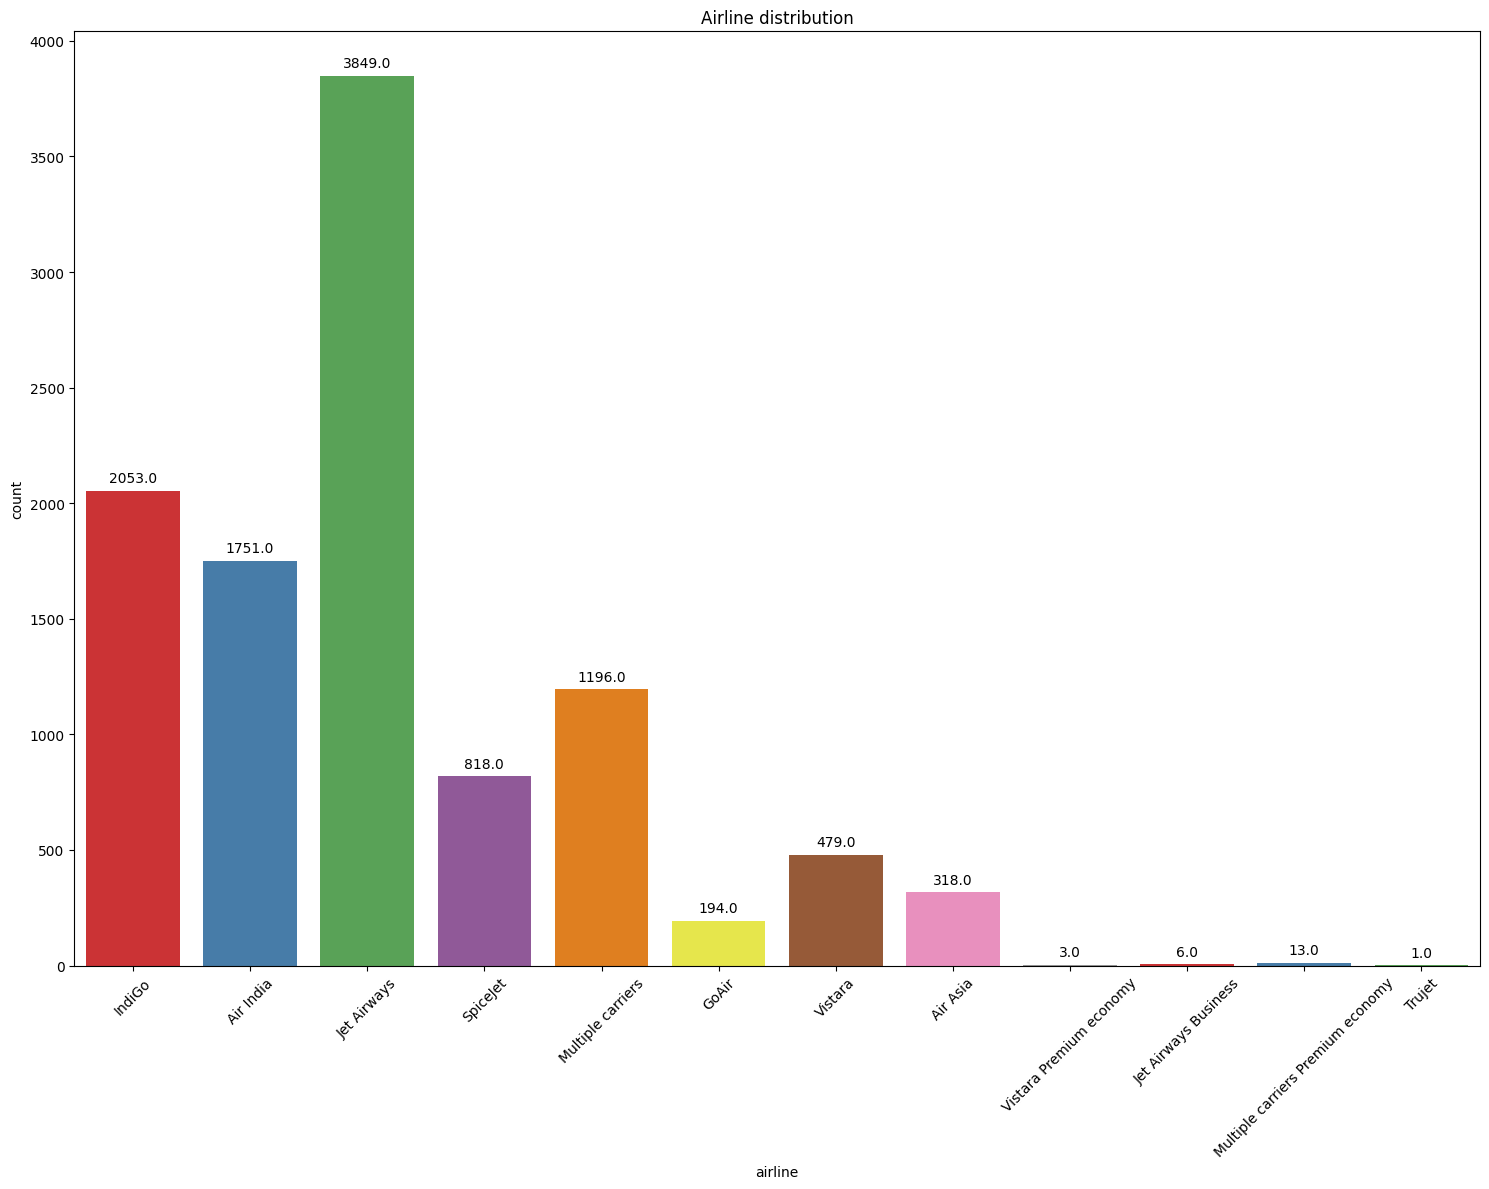

In [9]:
plt.figure(figsize=(15,12),dpi=100)
ax=sns.countplot(data=df, x='airline',palette='Set1')
plt.title('Airline distribution')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 9), 
    textcoords = 'offset points')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

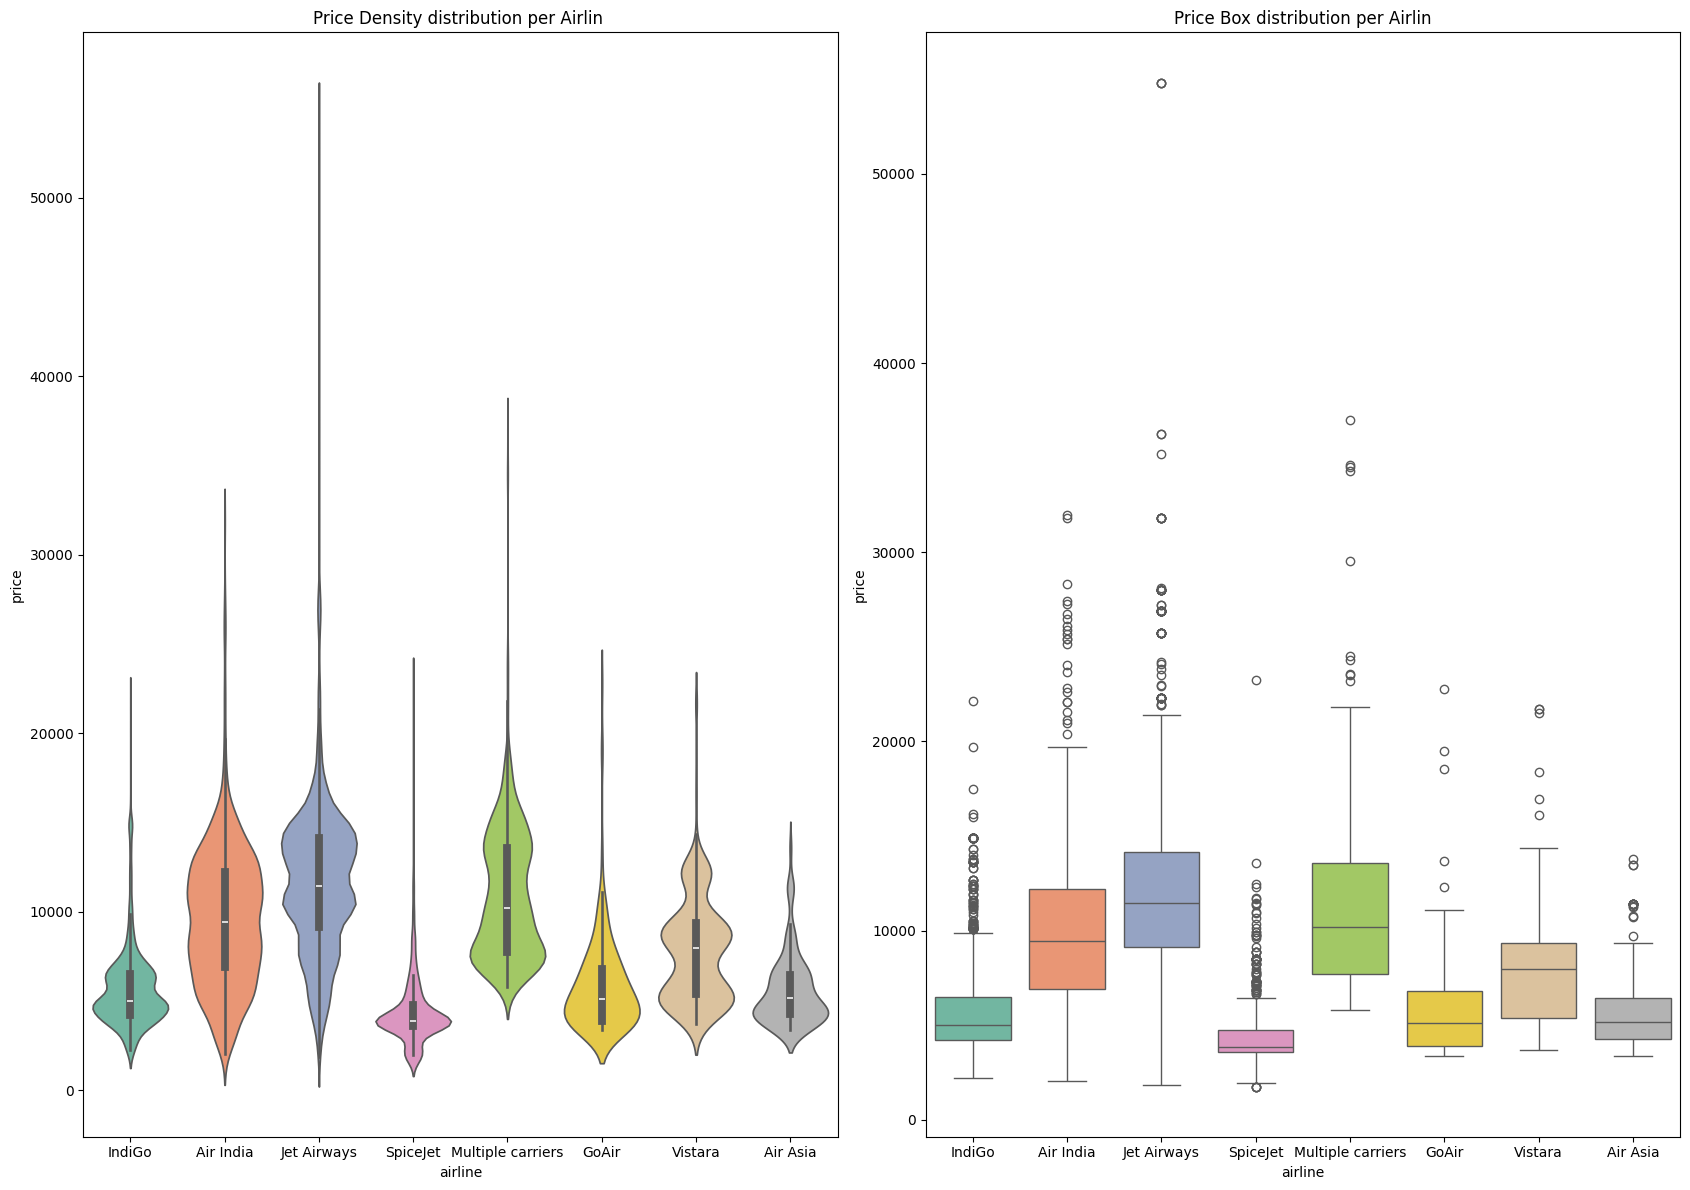

In [10]:
#remove outlier airlines from the dataset as shown at the above plot
df_airlines=df[~df['airline'].isin(['Vistara Premium economy', 'Jet Airways Business','Multiple carriers Premium economy', 'Trujet'])]


#creates the figure and divide it to 2 different plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 12), dpi=100)

# Plot 1: Benefits distribution
ax1 =sns.violinplot(data=df_airlines, x='airline',y='price',palette='Set2',ax=ax1)
ax1.set_title('Price Density distribution per Airlin ')

# Plot 2: Requirements distribution
ax2 =sns.boxplot(data=df_airlines, x='airline',y='price',palette='Set2',ax=ax2)
ax2.set_title('Price Box distribution per Airlin')
# Adjust spacing and show plot
plt.tight_layout()
plt.show()

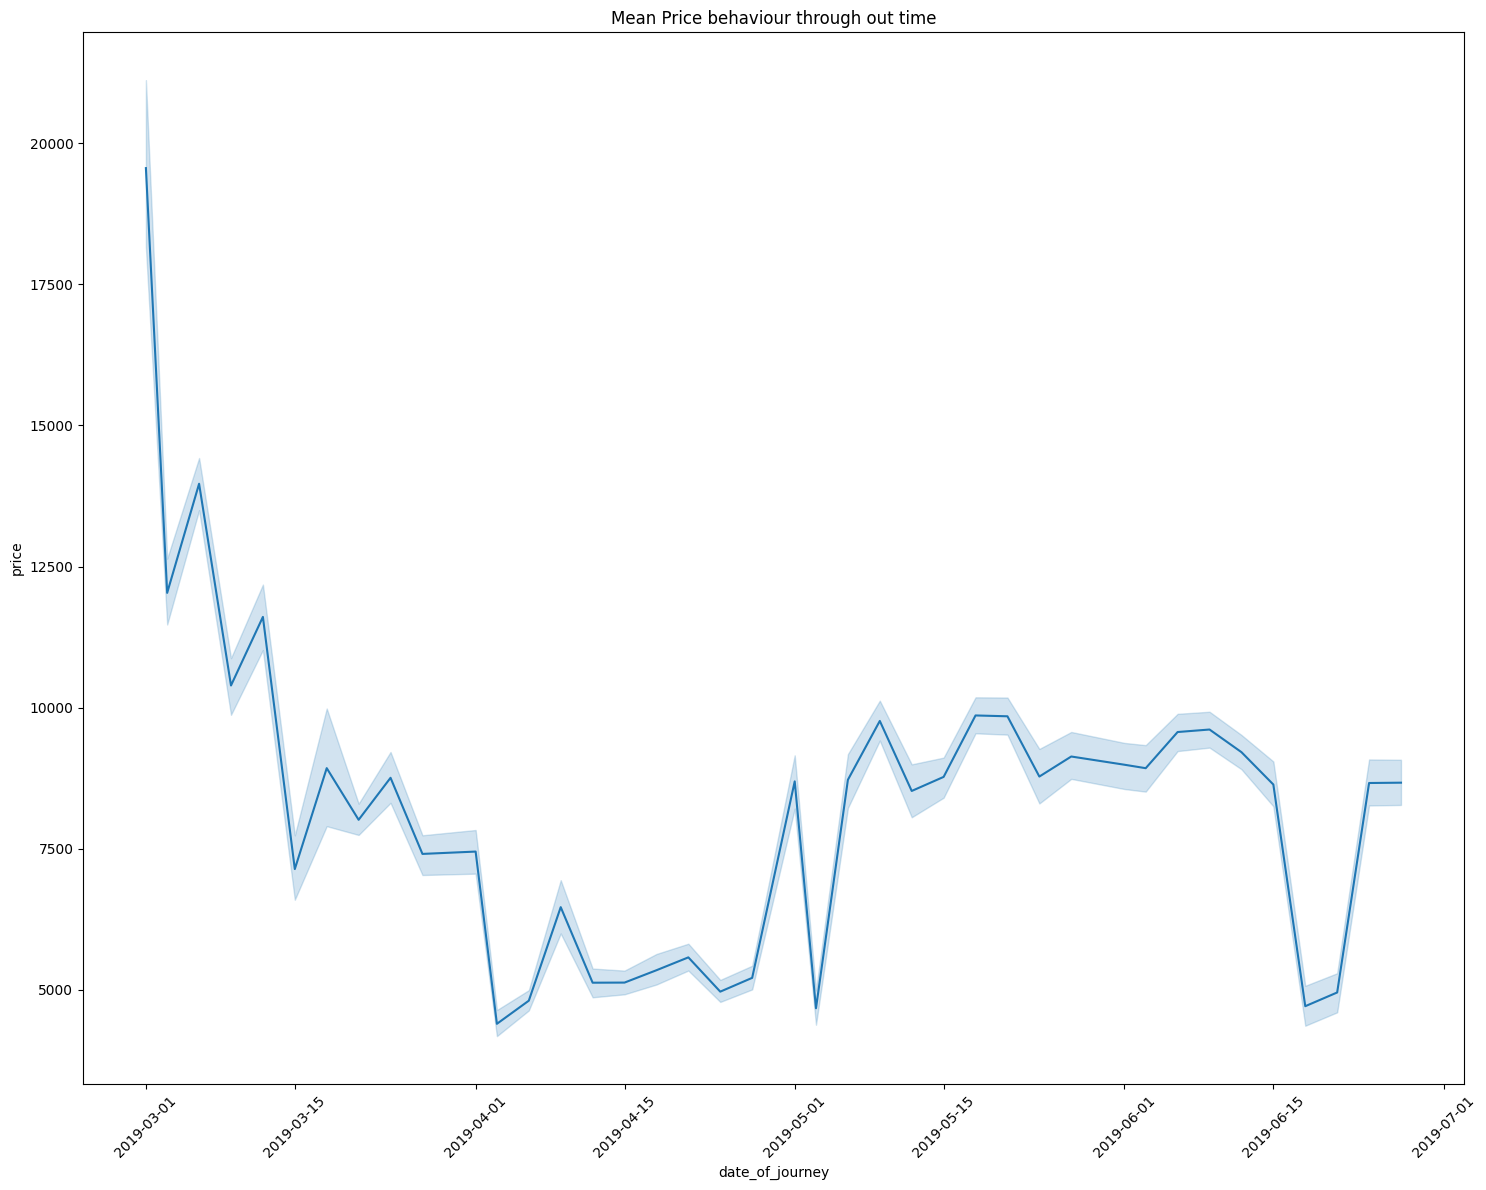

In [11]:
plt.figure(figsize=(15,12),dpi=100)
plt.title('Mean Price behaviour through out time')
sns.lineplot(data=df, x='date_of_journey',y='price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df['additional_info'].unique()

array(['no info', 'in-flight meal not included',
       'no check-in baggage included', 'layover', 'change airports',
       'business class'], dtype=object)

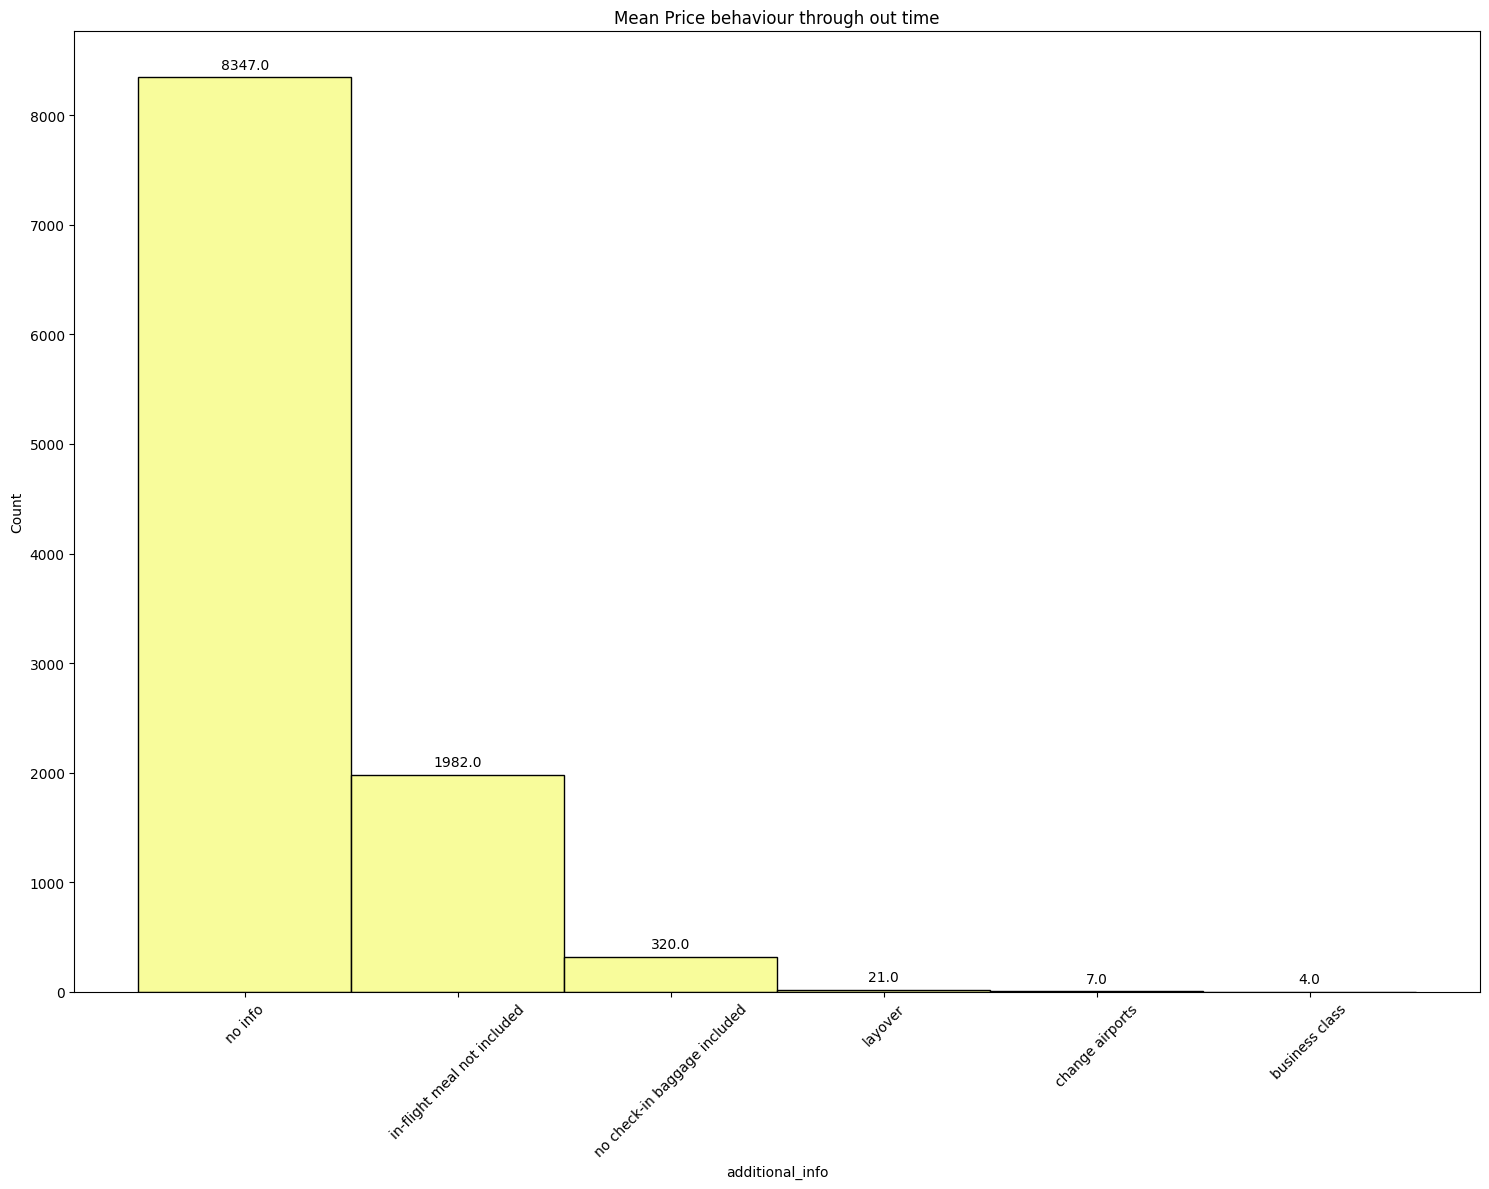

In [13]:
plt.figure(figsize=(15,12),dpi=100)
plt.title('Mean Price behaviour through out time')
ax=sns.histplot(data=df, x='additional_info',color='#F6FB7A')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 9), 
    textcoords = 'offset points')

plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

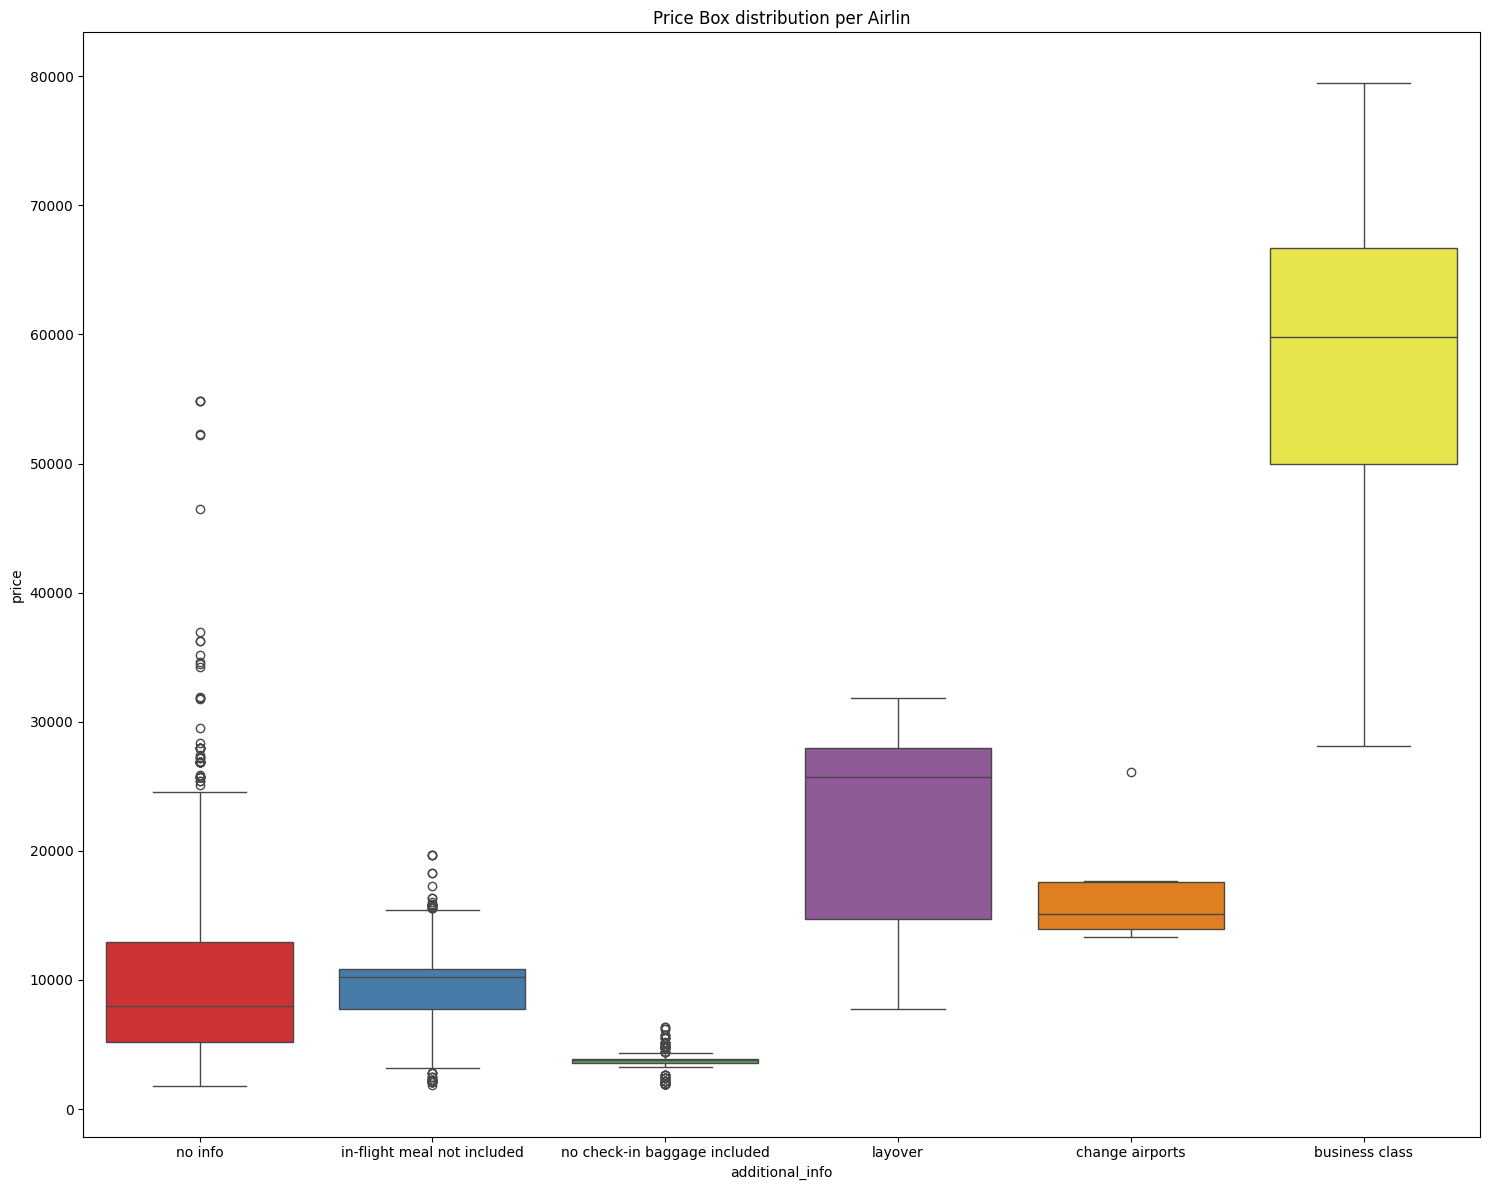

In [14]:
plt.figure(figsize=(15,12),dpi=100)
sns.boxplot(data=df, x='additional_info',y='price',palette='Set1')
plt.title('Price Box distribution per Airlin')
# Adjust spacing and show plot
plt.tight_layout()
plt.show()

In [126]:
hour_str = "22:37"

# Parse the string into a datetime object
time_obj = datetime.strptime(hour_str, "%H:%M")  # %H for hours in 24-hour format

# Extract the hour as an integer
hour_int = time_obj

print(hour_int)  # Output: 22

1900-01-01 22:37:00


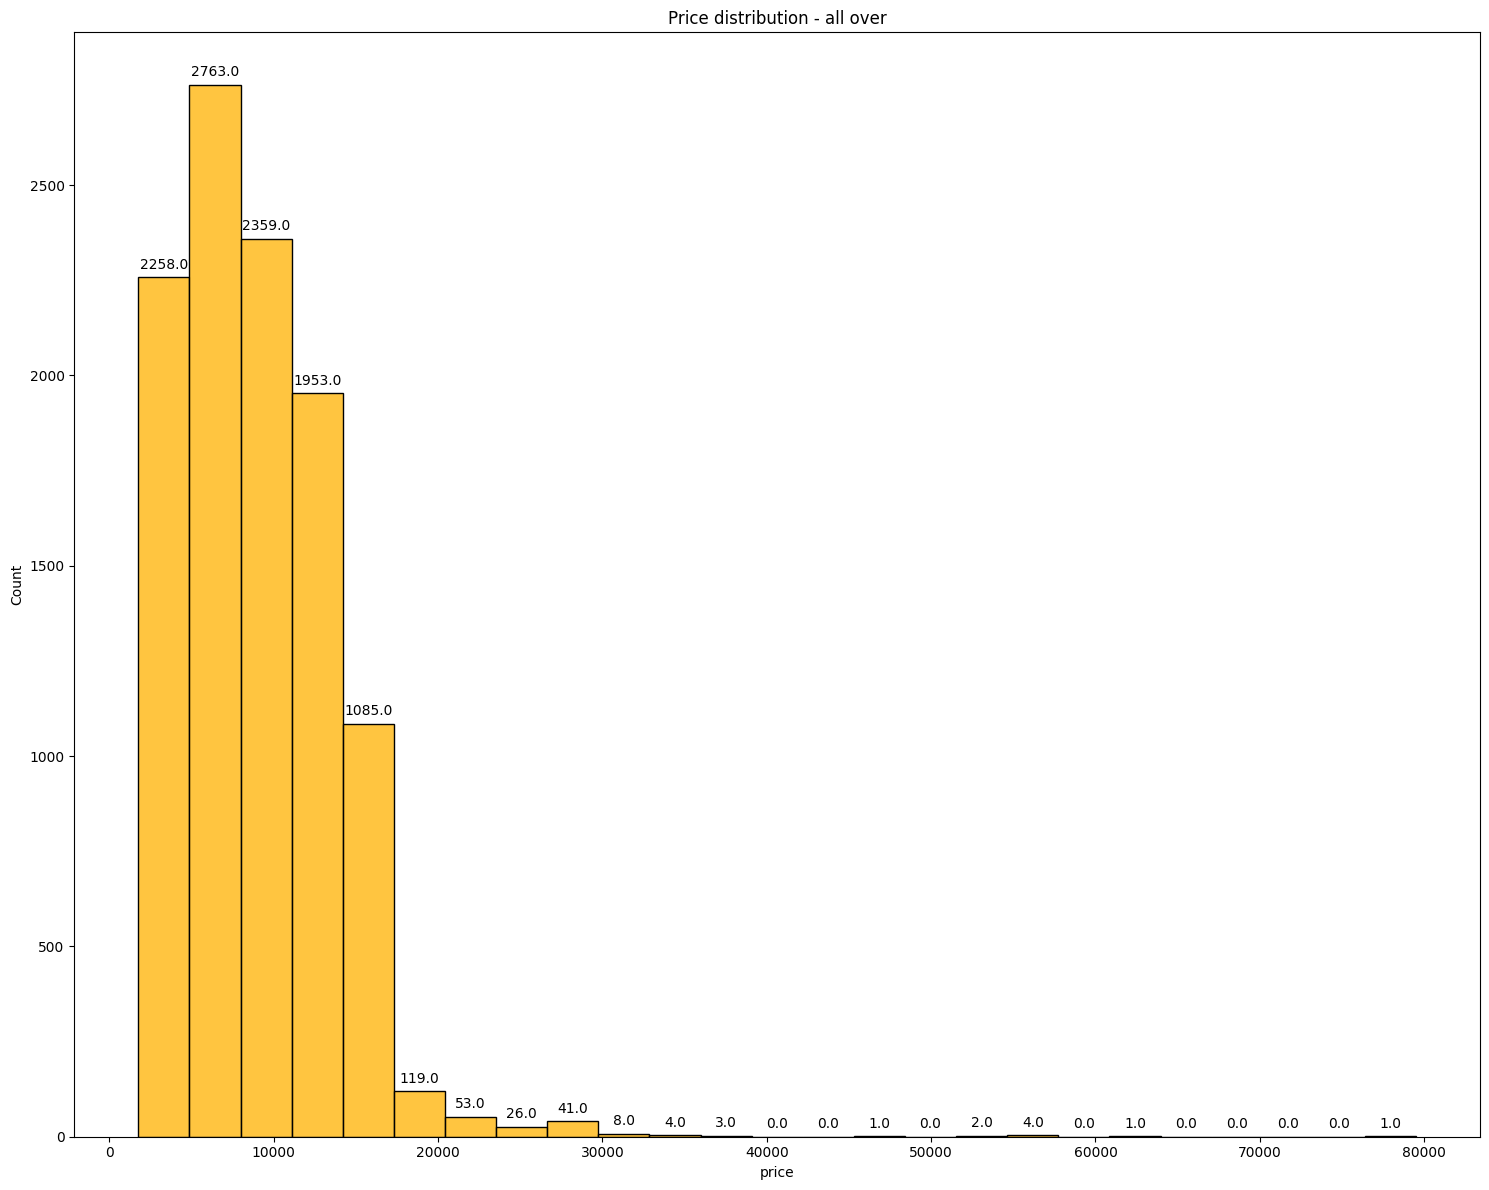

In [37]:
plt.figure(figsize=(15,12),dpi=100)
ax=sns.histplot(data=df, x='price', bins=25, color='#FFB200')
plt.title('Price distribution - all over')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
    (p.get_x() + p.get_width() / 2., p.get_height()), 
    ha = 'center', va = 'center', 
    xytext = (0, 9), 
    textcoords = 'offset points')

# Adjust spacing and show plot
plt.tight_layout()
plt.show()

<Figure size 1500x1200 with 0 Axes>

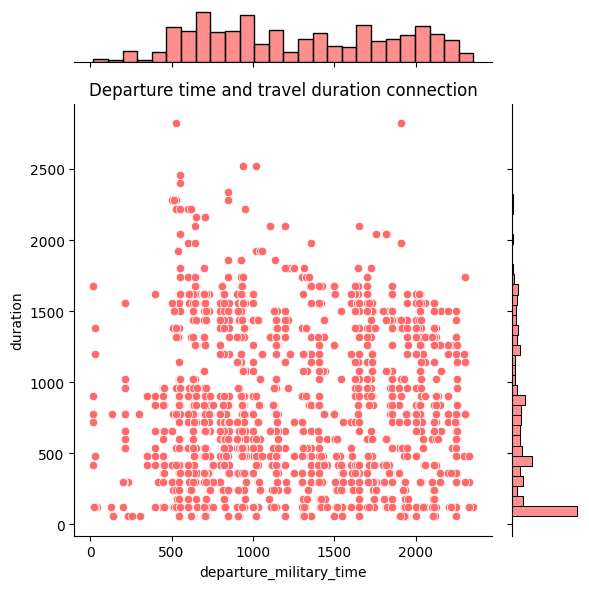

In [51]:
plt.figure(figsize=(15,12),dpi=100)
ax=sns.jointplot(data=df, x='departure_military_time',y='duration', color='#FF6969')
plt.title('Departure time and travel duration connection')

# Adjust spacing and show plot
plt.tight_layout()
plt.show()

## Final cleaning

In [71]:
df=df[~df['airline'].isin(['Vistara Premium economy', 'Jet Airways Business','Multiple carriers Premium economy', 'Trujet'])]
df.drop(columns=['route','arrival_time','dep_time'],inplace=True)


# now = datetime.now()
# date_string = now.strftime("%Y%m%d%H%M%S")
# date_int = int(date_string)
# print(date_string)

# Preprocessing

In [113]:
x=df.drop(columns=['price'],axis=1)
y=df['price']

X_train,X_val,y_train,y_val=split(x,y,shuffle=True,test_size=0.25,random_state=42)

In [114]:
class myOneHotEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        super().__init__()
        self.ohe=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
        
    
    def fit(self,X,y=None):
        self.ohe.fit(X.select_dtypes(['datetime','object']))
        return self
    
    
    def transform(self,X):
        X_rest=pd.DataFrame(self.ohe.transform(X.select_dtypes(['datetime','object'])))
        X_numeric=X.select_dtypes('number')
        
        output=np.concatenate([X_rest,X_numeric],axis=1)       
        
        return output

In [115]:
# create a pipline
my_pipe=Pipeline(steps=[('ohe',myOneHotEncoder()),('scaler',MinMaxScaler())])


X_train_model=my_pipe.fit_transform(X_train)
X_val_model=my_pipe.transform(X_val)

print(f'train shape:\t{X_train_model.shape},\nval shape:\t{X_val_model.shape}')

train shape:	(7993, 67),
val shape:	(2665, 67)


# Model

## SARIMAX

In [ ]:
!pip install pmdarima #run time series cells only on google colab IDE

In [144]:
#Time series lib
from statsmodels.tsa.arima_model import ARMA,ARIMA, ARIMAResults,ARMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf,acf,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing

## Ridge Regression

In [121]:
from sklearn.linear_model import Ridge

ridge=Ridge(random_state=42)

alpha=np.linspace(0,10,50)

grid_params={'alpha':alpha}

ridge_model=GridSearchCV(estimator=ridge,param_grid=grid_params,scoring='neg_mean_squared_error',cv=4)

In [122]:
ridge_model.fit(X_train_model,y_train)

GridSearchCV(cv=4, estimator=Ridge(random_state=42),
             param_grid={'alpha': array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])},
             scoring='neg_mean_squared_error')

In [123]:
ridge_model.best_params_

{'alpha': np.float64(0.20408163265306123)}

In [124]:
y_pred=ridge_model.predict(X_val_model)

In [153]:
rmse=np.sqrt(mean_squared_error(y_val,y_pred))
mae=mean_absolute_error(y_val,y_pred)
r2=r2_score(y_val,y_pred)
mape=mean_absolute_percentage_error(y_val,y_pred)
data_mean=df['price'].describe().loc['mean']
data_std=df['price'].describe().loc['std']
score_dict={'RMSE':rmse,'MAE':mae,'Mean':data_mean,'STD':data_std,'R^2':r2,'MAPE':mape}
pd.DataFrame(score_dict.values(),score_dict.keys()).T

,RMSE,MAE,Mean,STD,R^2,MAPE
0,2257.342981,1508.161807,9056.040721,4456.719755,0.748177,0.184309


## XGBoost

In [170]:
from xgboost import XGBRegressor

#initiate the model
my_xgb=XGBRegressor()

#set the hyperparameters
learning_rate=[0.01,0.05,0.1,0.2]
max_depth=[2,3,5,7]
n_estimators=[100,150]
gamma=[0.0,0.1,0.2,0.3,0.4]
scale_pos_weight=[1,3,5]
max_features=[0.25,0.5,0.75,1]
subsample=[0.5,0.75,0.9]
reg_lambda=np.linspace(0.1,1,20)
min_child_weight=[1,3,5]

model_params={'learning_rate': learning_rate,
            'max_depth': max_depth,
            'n_estimators': n_estimators,
            'gamma': gamma,
            'subsample':subsample,
            'scale_pos_weight': scale_pos_weight,
            'max_features': max_features,
            'reg_lambda':reg_lambda,
            'min_child_weight':min_child_weight}


rand_model=RandomizedSearchCV(estimator=my_xgb,param_distributions=model_params,n_iter=50,scoring='neg_mean_squared_error',random_state=42)

In [165]:
my_xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [171]:
rand_model.fit(X_train_model,y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                        'n_estimators': [100, 150],
                                        'reg_lambda': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.75, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error')

In [176]:
rand_model.best_params_

{'subsample': 0.75,
 'scale_pos_weight': 5,
 'reg_lambda': np.float64(0.19473684210526315),
 'n_estimators': 150,
 'min_child_weight': 5,
 'max_features': 0.25,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0}

In [175]:
y_pred=rand_model.predict(X_val_model)

In [177]:
rmse=np.sqrt(mean_squared_error(y_val,y_pred))
mae=mean_absolute_error(y_val,y_pred)
r2=r2_score(y_val,y_pred)
mape=mean_absolute_percentage_error(y_val,y_pred)
data_mean=df['price'].describe().loc['mean']
data_std=df['price'].describe().loc['std']
score_dict={'RMSE':rmse,'MAE':mae,'Mean':data_mean,'STD':data_std,'R^2':r2,'MAPE':mape}
pd.DataFrame(score_dict.values(),score_dict.keys()).T

,RMSE,MAE,Mean,STD,R^2,MAPE
0,1608.609545,870.791737,9056.040721,4456.719755,0.872121,0.10095


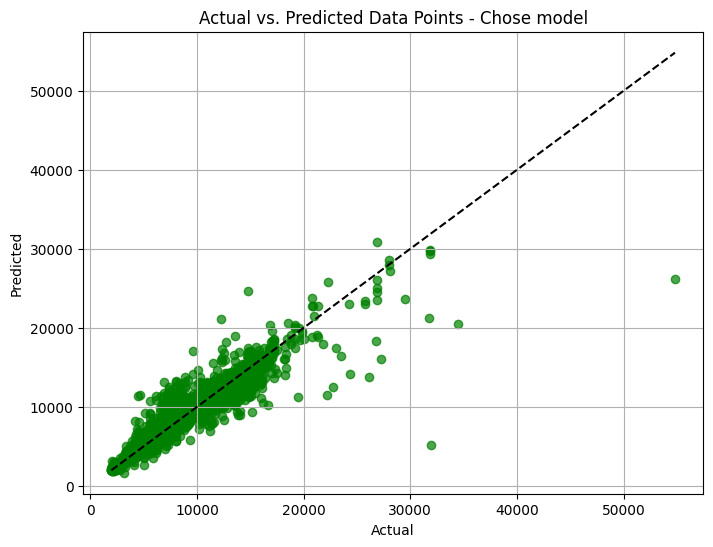

In [179]:
# as much as data points are close to the linear red strict line  the more points we are right to predict their prices
plt.figure(figsize=(8, 6),dpi=100)
plt.scatter(y_val, y_pred, color='green', alpha=0.7)
plt.plot([y_val.min(), y_val.max()],[y_val.min(), y_val.max()], color='black', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Data Points - Chose model')
plt.grid(True)
plt.show()